In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [6]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-0.7, 0, 6)
epsilon_range=np.logspace(-3.5, -2, 5)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits

C=0.19952623149688797
eps=0.01


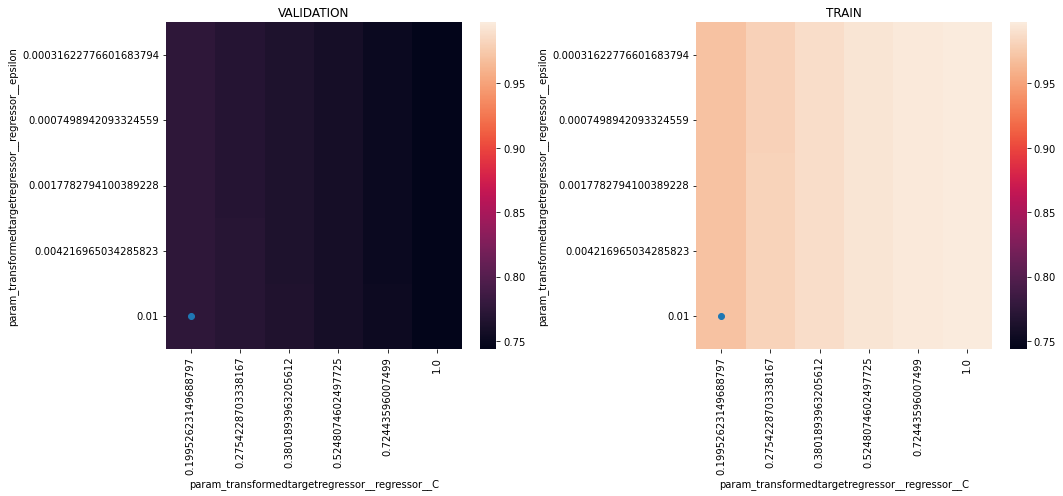

In [27]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [28]:
C_range=np.logspace(-1.4, -0.7, 6)
epsilon_range=np.logspace(-0.5, -2, 5)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Fitting 1 folds for each of 30 candidates, totalling 30 fits

C=0.054954087385762455
eps=0.01


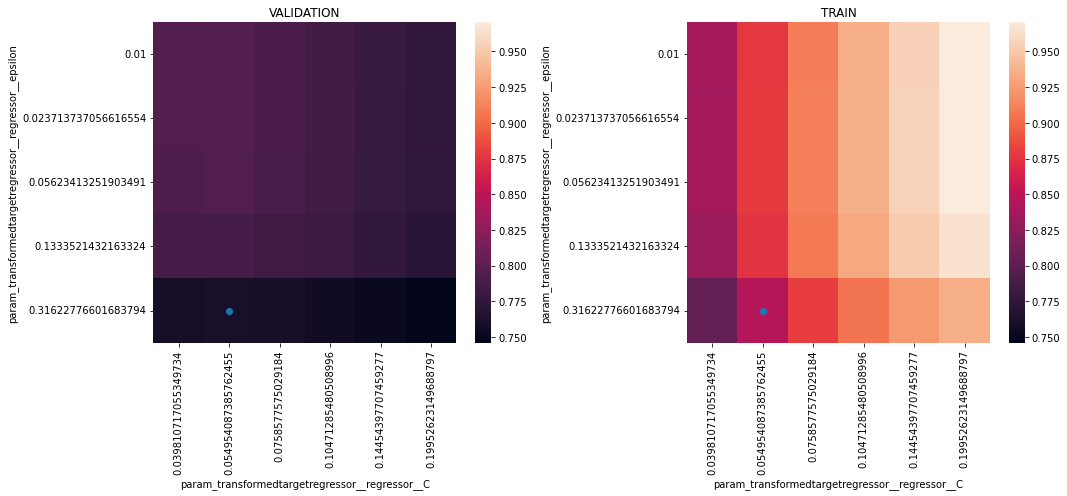

In [29]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [7]:
C=0.054954087385762455
eps=0.01

In [13]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

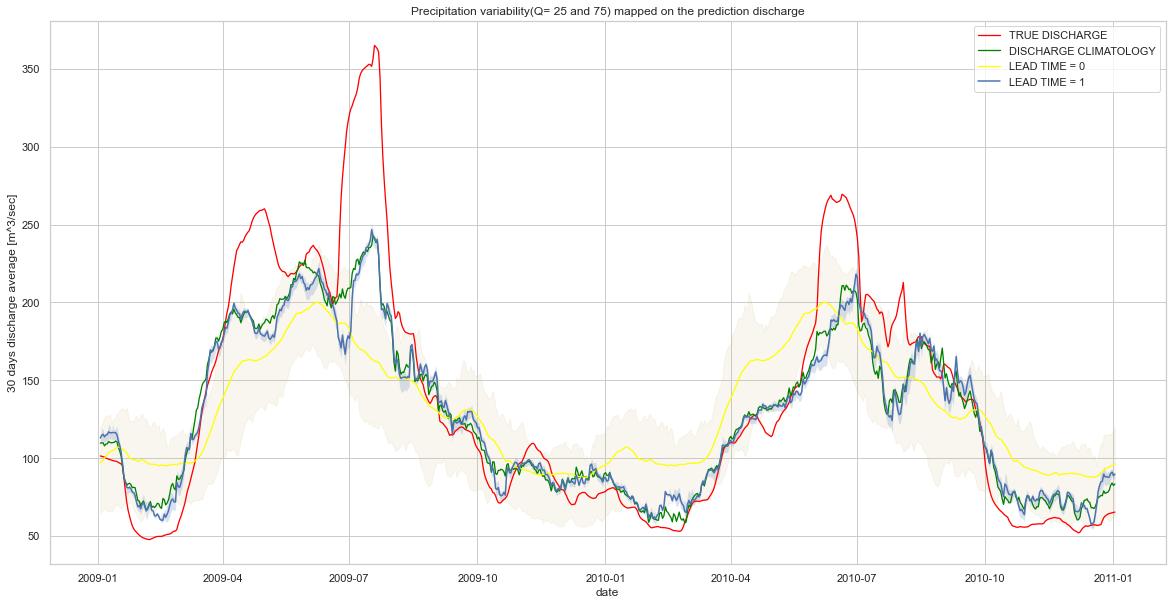

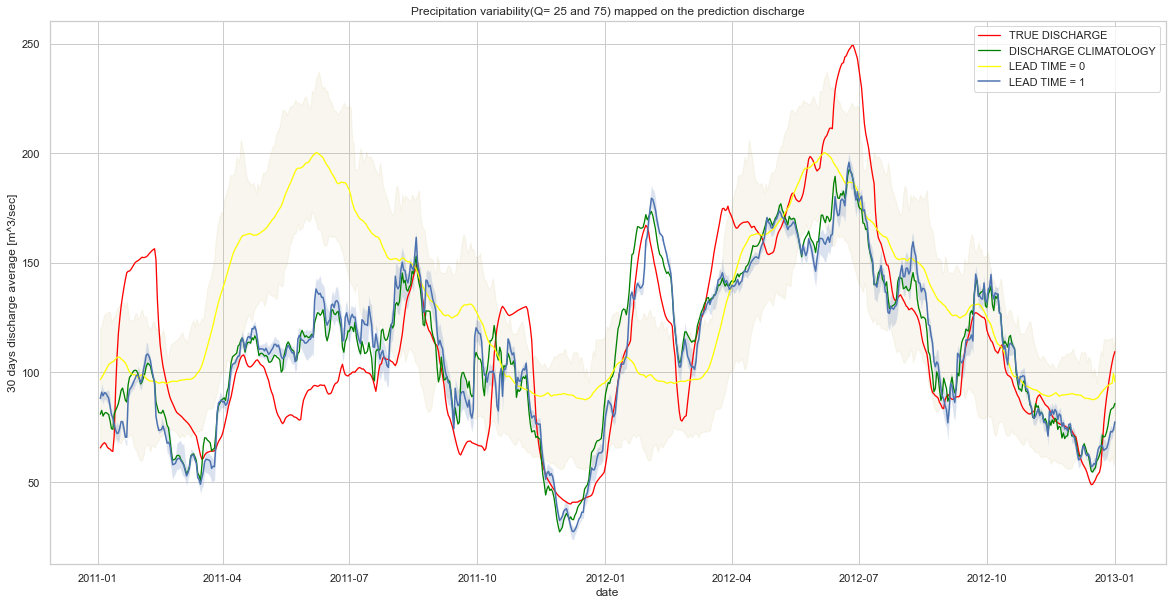

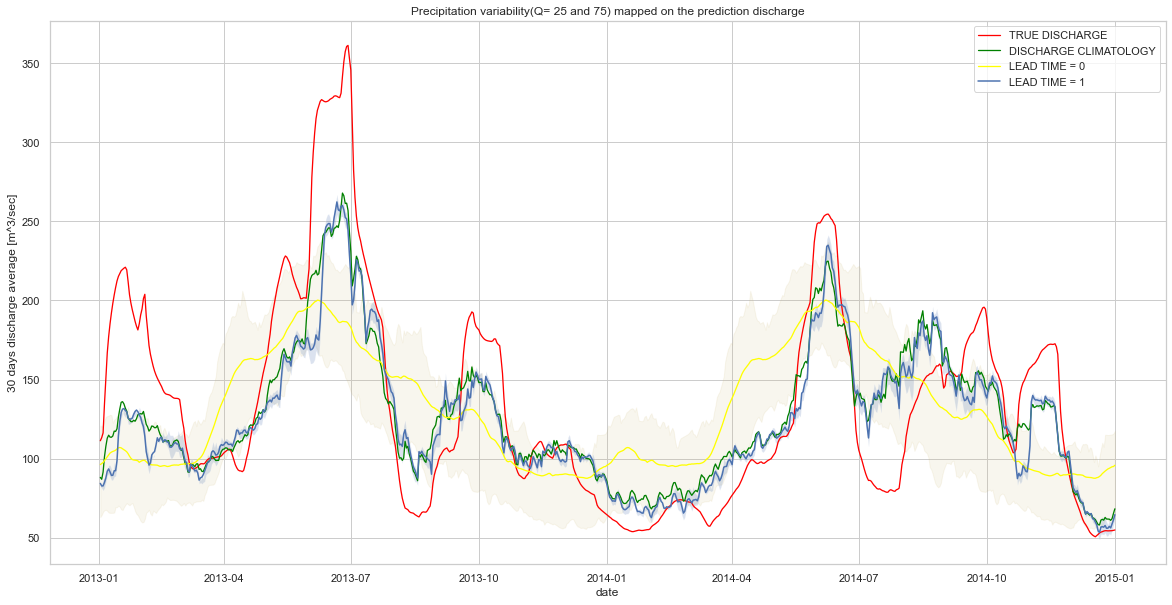

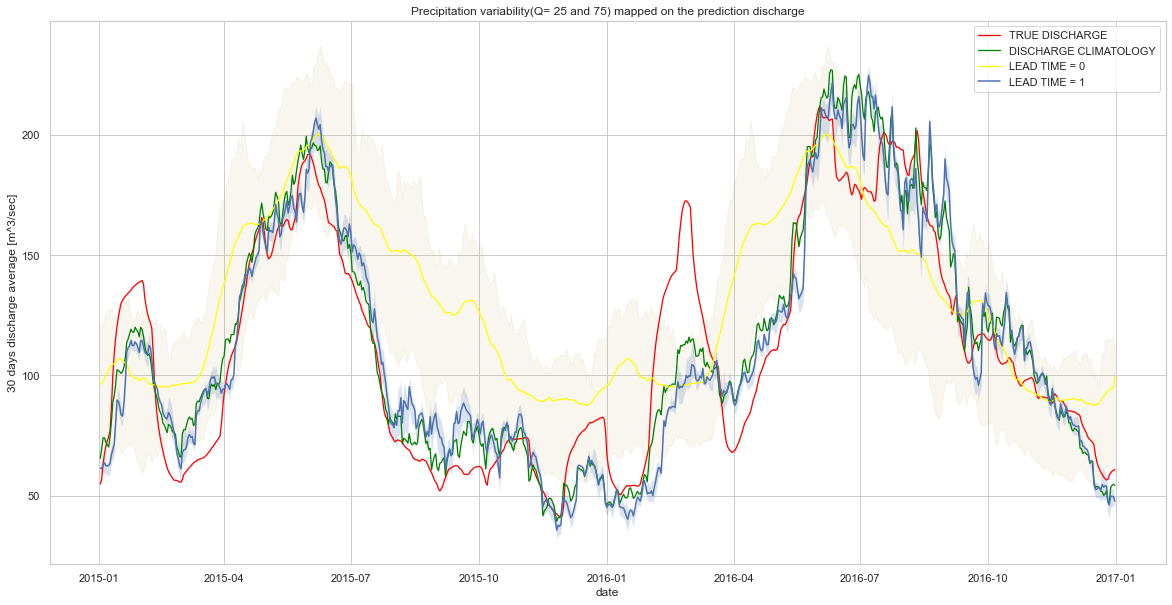

In [14]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


In [16]:
from test import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

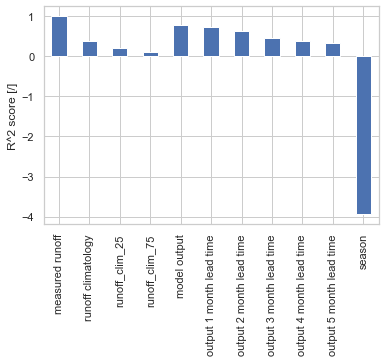

In [17]:
r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

measured runoff             1.000000
runoff climatology          0.380197
runoff_clim_25              0.198106
runoff_clim_75              0.095323
model output                0.782736
output 1 month lead time    0.738496
output 2 month lead time    0.624995
output 3 month lead time    0.459511
output 4 month lead time    0.380432
output 5 month lead time    0.342819
dtype: float64

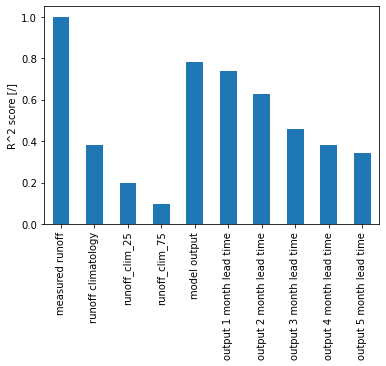

In [10]:
evaluate_prediction(predictions)

measured runoff             1.000000
runoff climatology          0.377234
model output                0.787669
output 1 month lead time    0.735637
output 2 month lead time    0.622263
output 3 month lead time    0.455217
output 4 month lead time    0.377968
output 5 month lead time    0.336190
dtype: float64

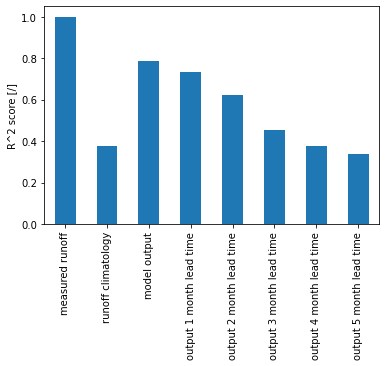

In [32]:
#old
evaluate_prediction(predictions)

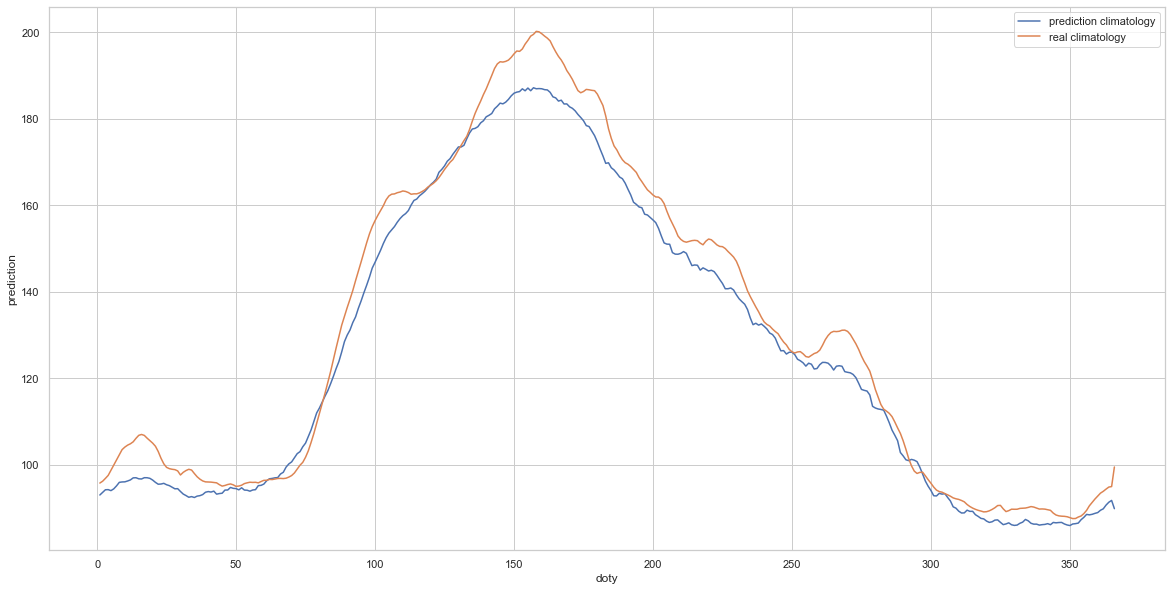

In [8]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

In [9]:
from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [11]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from sf_runoff import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_AT31_0254.joblib']